WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Loading and preparing data...

Creating Linear model (order=1)...
Sampling from Linear model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 71 seconds.


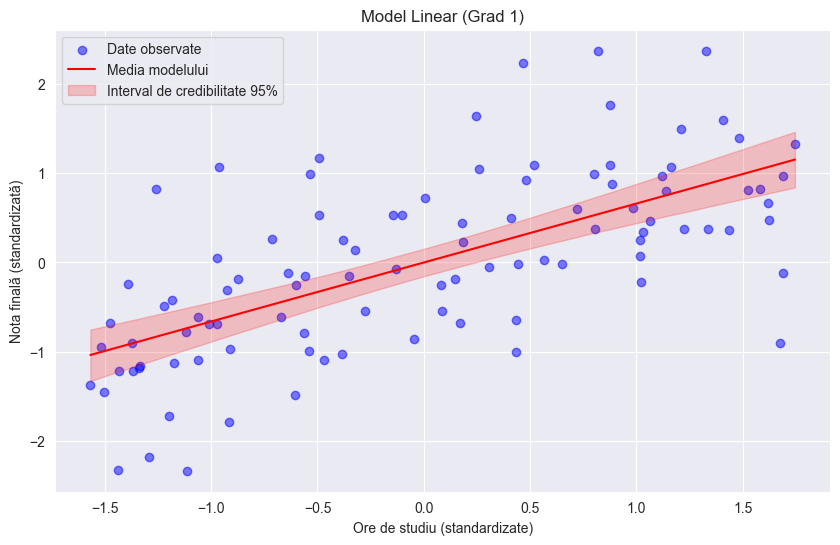


Creating Pătratic model (order=2)...
Sampling from Pătratic model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 79 seconds.


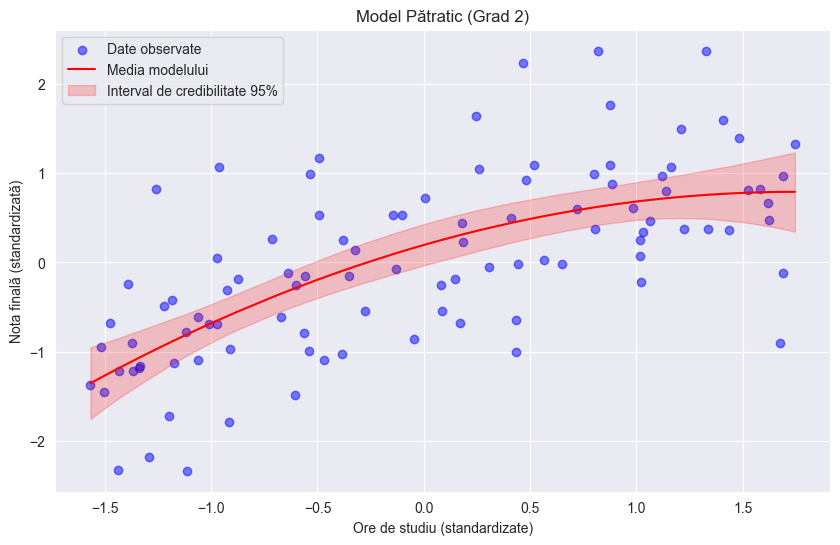


Creating Cubic model (order=3)...
Sampling from Cubic model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 116 seconds.


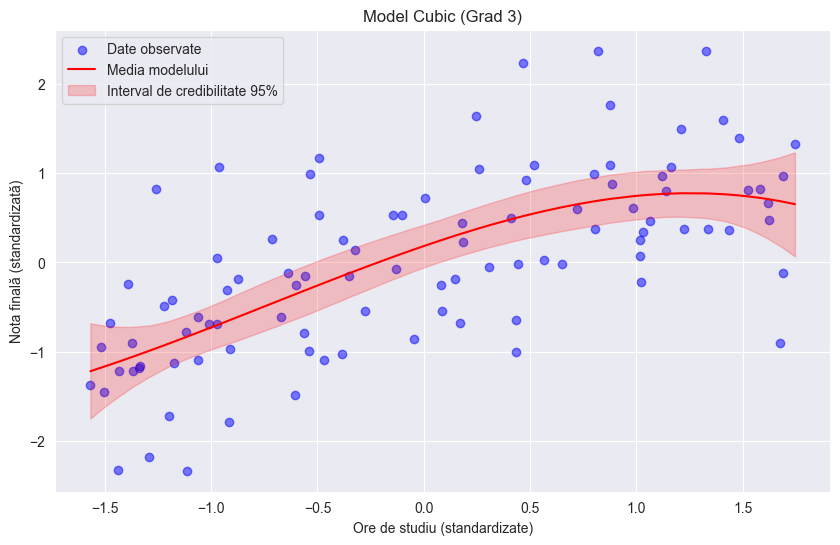


Comparație modele folosind WAIC:


C:\Users\mihai\PycharmProjects\PMP-2024\venv\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\mihai\PycharmProjects\PMP-2024\venv\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\mihai\PycharmProjects\PMP-2024\venv\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(



Rezultate comparație WAIC:
         rank   elpd_waic    p_waic  elpd_diff    weight         se       dse  \
model_p     0  230.316225  3.956412   0.000000  0.491685  14.443997  0.000000   
model_c     1  231.688045  4.769078   1.371819  0.276881  14.070537  1.484681   
model_l     2  233.305652  3.140495   2.989427  0.231434  14.878794  4.116413   

         warning     scale  
model_p     True  deviance  
model_c     True  deviance  
model_l     True  deviance  


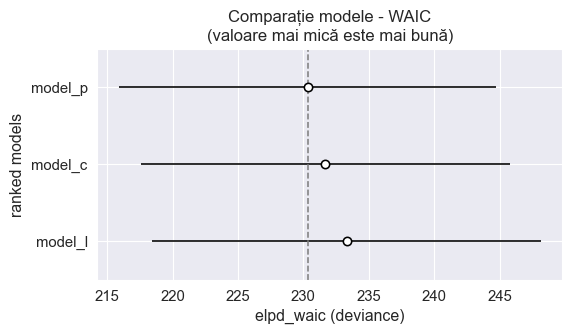


Comparație modele folosind LOO:

Rezultate comparație LOO:
         rank    elpd_loo     p_loo  elpd_diff    weight         se       dse  \
model_p     0  230.341430  3.969015   0.000000  0.488097  13.953222  0.000000   
model_c     1  231.743323  4.796717   1.401893  0.262952  13.584360  1.481960   
model_l     2  233.325940  3.150639   2.984510  0.248951  14.882293  4.116955   

         warning     scale  
model_p    False  deviance  
model_c    False  deviance  
model_l    False  deviance  


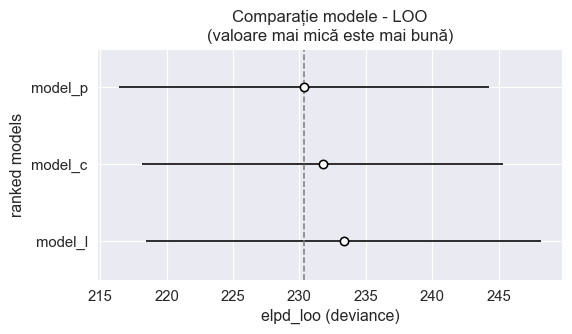

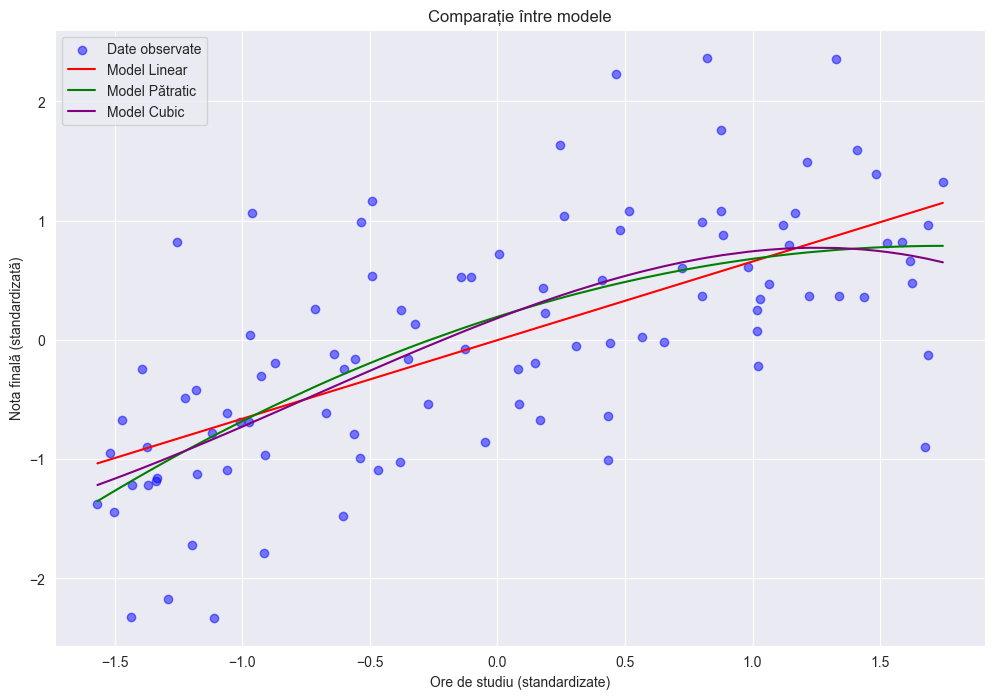

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

# Load and prepare data
print("Loading and preparing data...")
data = pd.read_csv('date_studiu_nota.csv')
X = data['Ore_Studiu'].values
y = data['Nota_Finala'].values

# Standardize the data
X_std = (X - X.mean()) / X.std()
y_std = (y - y.mean()) / y.std()

# Function to create polynomial features
def create_polynomial_features(X, order):
    return np.column_stack([X**i for i in range(1, order + 1)])

# Function to plot individual model
def plot_single_model(X, y, trace, order, title):
    plt.figure(figsize=(10, 6))
    
    # Sort X for smooth lines
    X_sort_idx = np.argsort(X)
    X_sorted = X[X_sort_idx]
    
    # Plot data points
    plt.scatter(X, y, color='blue', alpha=0.5, label='Date observate')
    
    # Get posterior samples
    alpha_samples = trace.posterior['alpha'].values.flatten()
    beta_samples = trace.posterior['beta'].values.reshape(-1, order)
    
    # Calculate predictions
    X_poly = create_polynomial_features(X_sorted, order)
    y_pred = alpha_samples[:, None] + np.dot(beta_samples, X_poly.T)
    
    # Calculate mean and credible intervals
    y_mean = y_pred.mean(axis=0)
    y_lower = np.percentile(y_pred, 2.5, axis=0)
    y_upper = np.percentile(y_pred, 97.5, axis=0)
    
    # Plot
    plt.plot(X_sorted, y_mean, color='red', label='Media modelului')
    plt.fill_between(X_sorted, y_lower, y_upper, color='red', alpha=0.2, 
                    label='Interval de credibilitate 95%')
    
    plt.xlabel('Ore de studiu (standardizate)')
    plt.ylabel('Nota finală (standardizată)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create and sample from model
def create_model(X, y, order, name):
    print(f"\nCreating {name} model (order={order})...")
    with pm.Model() as model:
        # Priors
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        betas = pm.Normal('beta', mu=0, sigma=10, shape=order)
        sigma = pm.HalfNormal('sigma', sigma=10)

        # Create polynomial features
        X_poly = create_polynomial_features(X, order)
        
        # Linear predictor
        mu = alpha + pm.math.dot(betas, X_poly.T)
        
        # Likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
        
        # Sample
        print(f"Sampling from {name} model...")
        with model:
            idata = pm.sample(2000, 
                            return_inferencedata=True, 
                            idata_kwargs={"log_likelihood": True})
            
        # Plot individual model
        plot_single_model(X_std, y_std, idata, order, 
                         f'Model {name} (Grad {order})')
        
        return idata, model

if __name__ == '__main__':
    # Create and sample from models sequentially
    models = {
        'model_l': (1, 'Linear'),
        'model_p': (2, 'Pătratic'),
        'model_c': (3, 'Cubic')
    }
    
    results = {}
    model_objects = {}
    for model_name, (order, label) in models.items():
        trace, model = create_model(X_std, y_std, order, label)
        results[model_name] = trace
        model_objects[model_name] = model
    
    # Compare models using WAIC
    print("\nComparație modele folosind WAIC:")
    comparison_waic = az.compare(
        {
            'model_l': results['model_l'], 
            'model_p': results['model_p'],
            'model_c': results['model_c']
        },
        method='BB-pseudo-BMA',
        ic='waic',
        scale='deviance'
    )
    
    print("\nRezultate comparație WAIC:")
    print(comparison_waic)
    
    # Plot WAIC comparison
    az.plot_compare(comparison_waic)
    plt.title("Comparație modele - WAIC\n(valoare mai mică este mai bună)")
    plt.show()
    
    # Compare models using LOO
    print("\nComparație modele folosind LOO:")
    comparison_loo = az.compare(
        {
            'model_l': results['model_l'], 
            'model_p': results['model_p'],
            'model_c': results['model_c']
        },
        method='BB-pseudo-BMA',
        ic='loo',
        scale='deviance'
    )
    
    print("\nRezultate comparație LOO:")
    print(comparison_loo)
    
    # Plot LOO comparison
    az.plot_compare(comparison_loo)
    plt.title("Comparație modele - LOO\n(valoare mai mică este mai bună)")
    plt.show()
    
    # Combined plot of all models
    plt.figure(figsize=(12, 8))
    
    # Sort X for smooth lines
    X_sort_idx = np.argsort(X_std)
    X_sorted = X_std[X_sort_idx]
    
    # Plot data points
    plt.scatter(X_std, y_std, color='blue', alpha=0.5, label='Date observate')
    
    # Plot predictions for each model
    colors = ['red', 'green', 'purple']
    for (model_name, trace), color in zip(results.items(), colors):
        order = models[model_name][0]
        
        # Get posterior samples
        alpha_samples = trace.posterior['alpha'].values.flatten()
        beta_samples = trace.posterior['beta'].values.reshape(-1, order)
        
        # Calculate predictions
        X_poly = create_polynomial_features(X_sorted, order)
        y_pred = alpha_samples[:, None] + np.dot(beta_samples, X_poly.T)
        
        # Calculate mean and credible intervals
        y_mean = y_pred.mean(axis=0)
        
        # Plot only the mean line, without HDI
        plt.plot(X_sorted, y_mean, color=color, 
                label=f'Model {models[model_name][1]}')
    
    plt.xlabel('Ore de studiu (standardizate)')
    plt.ylabel('Nota finală (standardizată)')
    plt.title('Comparație între modele')
    plt.legend()
    plt.grid(True)
    plt.show()